# Traffic Road Safety Sign Detection
This project is to train a deep learning model to detecta and classify road sign in indian road.

Dataset used for this project is `Indian Traffic Sign Dataset` from Kaggle : https://www.kaggle.com/datasets/neelpratiksha/indian-traffic-sign-dataset?resource=download

In [1]:
# Loading data from drive(mounting the google drive to our project)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Folder containing all the images in folder format
data_path = '/content/drive/MyDrive/project/traffic-road-sign-detection/indian-traffic-sign-dataset/Images'

In [3]:
# csv file contains the folder number mapped to class name
labels_path = '/content/drive/MyDrive/project/traffic-road-sign-detection/indian-traffic-sign-dataset/traffic_sign.csv'

In [4]:
4# Importing important laibaries
import pandas as pd
import numpy as np

import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from collections import Counter

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [5]:
labels_df = pd.read_csv(labels_path)
labels_df.head(5)

,ClassId,Name
0,0,Give way
1,1,No entry
2,2,One-way traffic
3,3,One-way traffic
4,4,No vehicles in both directions


In [6]:
# Creating a classID -> Name mapping
class_name_mapping = labels_df.set_index("ClassId")["Name"].to_dict()

class_name = class_name_mapping.get(8)
class_name

'No entry for bullock carts'

In [7]:
# Data Transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5],
        std=[0.5])
])

In [8]:
# Device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

###The following custom dataset class is created because I was facing problem while loading the dataset as a dataloader for my model. The labels and the images were not matching when plain datasets.ImageFolder was used over the dataset

In [9]:
from PIL import Image
import os

class CustomTrafficSignDataset(Dataset):
    def __init__(self, root_dir, transform=None, train=True, batch_size=32):
        self.root_dir = root_dir
        self.transform = transform
        self.train = train
        self.batch_size = batch_size

        # There are 58 folders named 0 to 58 and 39th folder is missing
        self.folder_names = [str(folder) for folder in range(59) if folder!=39]
        self.image_per_folder = 201
        self.train_images_per_folder = 196
        self.val_images_per_folder = 5

        # Calculating total number of images for training and validation
        if self.train:
            self.total_images = len(self.folder_names) * self.train_images_per_folder
        else:
            self.total_images = len(self.folder_names) * self.val_images_per_folder

        # Ensuring that the length is a multiple of batch size
        self.total_images = (self.total_images // self.batch_size) * self.batch_size

    def __len__(self):
        return self.total_images

    def __getitem__(self, idx):
        folder_name = self.folder_names[idx % len(self.folder_names)]
        folder_path = os.path.join(self.root_dir, folder_name)

        # Listing all files in the folder
        all_files = os.listdir(folder_path)

        # Filtering out required image files
        image_files = [file for file in all_files if file.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Segrigating index for train and test set
        if self.train:
            selected_files = image_files[: self.train_images_per_folder]
        else:
            selected_files = image_files[self.train_images_per_folder : self.image_per_folder]

        # Getting specific image from the selected files
        image_index = idx % len(selected_files)

        image_name = selected_files[image_index]
        image_path = os.path.join(folder_path, image_name)

        image = Image.open(image_path).convert("L")

        if self.transform:
            image = self.transform(image)

        label = int(folder_name)

        return image, torch.tensor(label)

        # # Setting empty variables for images and labels
        # images = []
        # labels = []

        # for img_name in selected_files:
        #     img_path = os.path.join(folder_path, img_name)
        #     # Load image
        #     image = Image.open(img_path).convert("L")

        #     if self.transform:
        #         image = self.transform(image)

        #     images.append(image)
        #     labels.append(int(folder_name))

        # return images, torch.tensor(labels)



# Temporary note: change the getitem function to extract the folder name rather then extracting the number in file name, because there are few images having wrong names

In [10]:
BATCH_SIZE = 32
# Creating an instance of custom dataset for training
train_dataset = CustomTrafficSignDataset(root_dir=data_path,
                                         transform=transform,
                                         train=True,
                                         batch_size=BATCH_SIZE)
# Creating an instance of custom dataset for validation
validation_dataset = CustomTrafficSignDataset(root_dir=data_path,
                                              transform=transform,
                                              train=False,
                                              batch_size=BATCH_SIZE)
len(train_dataset), len(validation_dataset)

(11360, 288)

In [11]:
# Creating training data loader
train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)
# Creating validation data loader
validation_loader = DataLoader(validation_dataset,
                               batch_size=BATCH_SIZE,
                               shuffle=False)
len(train_loader), len(validation_loader)

(355, 9)

class_info: 32    Loose gravel
Name: Name, dtype: object

Class name: Loose gravel
Random Label: 32


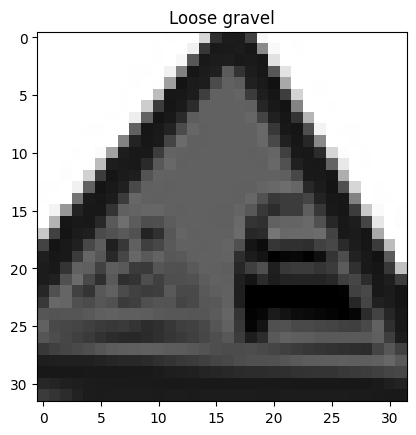

In [12]:
# Get a batch of data from the train_loader
images, labels = next(iter(train_loader))

# Choose a random index within the batch
random_index_within_batch = 8

# Extract the random image and label
random_image = images[random_index_within_batch]
random_label = labels[random_index_within_batch]

# Convert the PyTorch tensor to a NumPy array for visualization
random_image_np = random_image.squeeze().numpy()

# Denormalize the image
mean = 0.5
std = 0.5
sample_image = random_image_np * std + mean

class_label = random_label.item()
class_info = labels_df[labels_df['ClassId']==class_label]['Name']
print(f"class_info: {class_info}\n")
class_name = class_info.iloc[0]
print(f"Class name: {class_name}")

# Print the label and display the image
print(f'Random Label: {class_label}')






plt.imshow(sample_image, cmap='gray')  # Specify cmap for grayscale
plt.title(class_name)
plt.show()

shapes : torch.Size([1, 32, 32]), torch.Size([])
class_info: 8    No entry for bullock carts
Name: Name, dtype: object

Class name: No entry for bullock carts
Random Label: 8


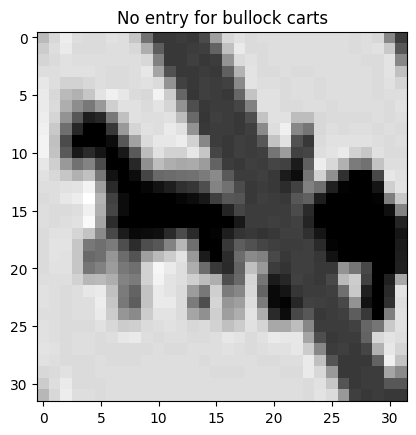

In [13]:
# Get a batch of data from the train_loader
images, labels = next(iter(validation_loader))

# Choose a random index within the batch
random_index_within_batch = 8

# Extract the random image and label
random_image = images[random_index_within_batch]
random_label = labels[random_index_within_batch]

print(f"shapes : {random_image.shape}, {random_label.shape}")

# Convert the PyTorch tensor to a NumPy array for visualization
random_image_np = random_image.squeeze().numpy()

# Denormalize the image
mean = 0.5
std = 0.5
sample_image = random_image_np * std + mean

class_label = random_label.item()
class_info = labels_df[labels_df['ClassId']==class_label]['Name']
print(f"class_info: {class_info}\n")
class_name = class_info.iloc[0]
print(f"Class name: {class_name}")

# Print the label and display the image
print(f'Random Label: {class_label}')
plt.imshow(sample_image, cmap='gray')  # Specify cmap for grayscale
plt.title(class_name)
plt.show()

In [14]:
# Checking device
print(next(iter(train_loader))[0].device)

cpu


# Model 1: Convolutional Neural Network model for classification
Model Source : https://poloclub.github.io/cnn-explainer/

In [15]:
# Creating CNN model
class TrafficSignalClassificationModelV1(nn.Module):
    """
    Model architecture is inspired from TineyVGG model from
    CNN explainer website
    """
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,  # The kernel size 3 is equivalent to (3, 3) touple, same as 3x3 matrix
                      stride=1,
                      padding=1),      # kernel_size, stride, padding are the Conv2d hyperparameters
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        # print(f"Output shape of clsssifier: {x.shape}")
        return x

In [16]:
# Running a forward pass to figure out the final linear layer in_features shapes
dummy_traffic_symbol_model = TrafficSignalClassificationModelV1(input_shape=1,
                                                          hidden_units=10,
                                                          output_shape=len(labels_df['ClassId'])).to(device)
next(dummy_traffic_symbol_model.parameters()).device

device(type='cpu')

In [17]:
random_image.unsqueeze(dim=0).shape

torch.Size([1, 1, 32, 32])

In [18]:
# Running sample image through a forward pass
dummy_traffic_symbol_model(random_image.unsqueeze(dim=0).to(device))

tensor([[ 2.6751e-02, -3.5181e-02, -3.4468e-02,  1.6242e-02, -6.0483e-02,
          1.8503e-02, -1.8266e-02,  4.8807e-02, -2.4429e-02, -5.6249e-03,
         -2.4996e-02, -7.8732e-03, -1.0498e-02, -7.4916e-03, -2.0555e-02,
          1.0631e-02,  5.1856e-03, -2.7611e-02, -1.8531e-02, -3.2820e-02,
          2.1690e-02,  3.3767e-02, -5.4775e-02,  5.1887e-03, -1.2633e-02,
          3.5160e-02,  1.1213e-02,  3.4251e-02,  1.5104e-02,  4.0308e-02,
         -3.1466e-03, -5.0026e-02, -3.1997e-02,  6.0415e-03, -2.7189e-02,
         -1.9776e-02,  2.5703e-02, -2.7056e-02, -1.4773e-02,  3.9568e-02,
         -4.2807e-02, -3.3916e-02,  1.0566e-02,  7.5822e-02, -3.5507e-03,
         -1.2756e-02, -2.0805e-02,  1.5440e-02,  1.6890e-02,  6.4221e-03,
          3.4286e-04,  1.8236e-02,  3.8907e-03,  5.1271e-05,  5.6974e-02,
          4.3659e-02,  2.7869e-02, -2.0794e-02, -2.8789e-02]],
       grad_fn=<AddmmBackward0>)

## The final layer input feature shape should be `hidden_units*8*8`

In [19]:
# Total number of classes
total_classes = len(labels_df['ClassId'])
print(f"Total classes : {total_classes}")

Total classes : 59


In [20]:
# Inidializing our model
SEED_VALUE = 50
torch.manual_seed(SEED_VALUE)

sign_class_model_v1 = TrafficSignalClassificationModelV1(input_shape=1,
                                                      hidden_units=10,
                                                      output_shape=total_classes).to(device)
sign_class_model_v1

TrafficSignalClassificationModelV1(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=640, out_features=59, bias=True)
  )
)

In [21]:
sign_class_model_v1.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.0787, -0.2875, -0.0738],
                        [-0.3064, -0.0658, -0.2372],
                        [-0.0264, -0.0082,  0.0618]]],
              
              
                      [[[ 0.3089, -0.2513, -0.0635],
                        [-0.0010,  0.3325,  0.0699],
                        [ 0.0153,  0.1316, -0.1663]]],
              
              
                      [[[-0.0917, -0.0253,  0.1430],
                        [ 0.0039, -0.2988, -0.1672],
                        [-0.1737, -0.0511, -0.3319]]],
              
              
                      [[[ 0.1232,  0.1665, -0.1674],
                        [-0.1007, -0.2032, -0.1472],
                        [-0.1649, -0.0805,  0.1791]]],
              
              
                      [[[ 0.1271,  0.1684, -0.2544],
                        [ 0.2466,  0.2261, -0.2979],
                        [-0.2197, -0.1391,  0.0455]]],
              
              
      

## Setting up loss function and optimizer for our model

In [22]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# # Setting Optimizer

# optimizer = torch.optim.SGD(params=sign_class_model_v1.parameters(),
#                              lr=0.1)

# optimizer = torch.optim.Adam(params=sign_class_model_v1.parameters(),
#                              lr=0.01,
#                              betas=(0.9, 0.999),
#                              eps=1e-4,
#                              weight_decay=1e-4,
#                              amsgrad=False)

learning_rate=0.01
weight_decy=1e-6
momentum=0.9
optimizer = torch.optim.SGD(params=sign_class_model_v1.parameters(),
                            lr=learning_rate,
                            momentum=momentum,
                            weight_decay=weight_decy)

In [23]:
# Accuracy function for evaluation
def accuracy_fn(y_true, y_pred):
    """
    Calculates accuracy between true labels and predicted labels
    Args:
      y_true (torch.Tensor): Ground Truth labels
      y_pred (torch.Tensor): Model predictions
    Returns:
      Accuracy value in parcentage % (torch.float)
    """
    correct_values = torch.eq(y_true, y_pred).sum().item()
    accuracy = (correct_values / len(y_true)) * 100
    return accuracy

## Creating training step function for training our model in batches

Steps:
1. Loop through epochs.
2. Loop through training batches, perform training steps

In [24]:
# Training Loop function
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device=device):
    """
    performs training loop to learn on data loader
    """
    train_loss, train_acc = 0, 0

    # Put model in training mode
    model.train()

    # Loop through training batches
    for batch, (X, y) in enumerate(data_loader):
        # Put data into target device
        X, y = X.to(device), y.to(device)

        # print(f"Batch --------> {batch}")
        # print(f"Image shape--> {X.shape}")
        # print(f"label shape--> {y.size()}")
        # Forward pass
        y_pred = model(X)

        # Calculate loss and accuracy (per batch)
        loss = loss_fn(y_pred, y)
        # accumulating training loss and traiing accuracy accross epochs
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # going from logits --> prediction labels

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step (Update the model parameter once per batch)
        optimizer.step()

    # Divide total train loss and accuracy by length of train dataloader to get the average value
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    # Print vervose
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")

## Creating a validation step function for validating model on unseen data
Steps:
1. Put model to inference mode
2. Loop through testing batches, perform testing steps, calculate test loss per batch

In [25]:
# Testing / Validation loop
def val_step(model: torch.nn.Module,
             data_loader: torch.utils.data.DataLoader,
             loss_fn: torch.nn.Module,
             accuracy_fn,
             device: torch.device=device):
    """
    This function performs a validation loop step over our dataloader
    """
    val_loss, val_acc = 0, 0

    # Put model in eval mode
    model.eval()

    # Turning on inference mode contaxt manager
    with torch.inference_mode():
        # Loop through data loader:
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            val_pred = model(X)

            # Calculate loss and accuracy
            val_loss += loss_fn(val_pred, y)
            val_acc += accuracy_fn(y_true=y,
                                   y_pred=val_pred.argmax(dim=1)) # go from raw logits to prediction labels

        # Getting the average validation loss and validation accuracy
        val_loss /= len(data_loader)
        val_acc /= len(data_loader)
        # Print vervose
        print(f"Validation loss: {val_loss:.5f} | Validation Accuracy: {val_acc:.2f}%")


## Now creating final model traing and validation loop

In [27]:

# Device agnostic code
if device == "cuda":
    torch.cuda.manual_seed(50)
elif device == "cpu":
    torch.manual_seed(50)

# Setting epoch value
epochs = 5 #35

# Main Loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n------->")
    train_step(model=sign_class_model_v1,
               data_loader=train_loader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    val_step(model=sign_class_model_v1,
             data_loader=validation_loader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
------->
Train loss: 1.51514 | Train acc: 59.57%
Validation loss: 1.59366 | Validation Accuracy: 63.19%
Epoch: 1
------->
Train loss: 0.99454 | Train acc: 72.67%
Validation loss: 1.46610 | Validation Accuracy: 62.50%
Epoch: 2
------->
Train loss: 0.71022 | Train acc: 80.04%
Validation loss: 1.79651 | Validation Accuracy: 64.58%
Epoch: 3
------->
Train loss: 0.53353 | Train acc: 84.75%
Validation loss: 1.73769 | Validation Accuracy: 67.01%
Epoch: 4
------->
Train loss: 0.45536 | Train acc: 87.75%
Validation loss: 1.79607 | Validation Accuracy: 66.32%


# Saving trained model for future use

In [ ]:
import os

# Create model directrory path
MODEL_PATH = "/content/drive/MyDrive/project/traffic-road-sign-detection"
FILE_NAME = "road-side-traffic-sign-detection-v01.pth"
SAVE_PATH = os.path.join(MODEL_PATH, FILE_NAME)

# Save the direct model
print(f"Saving model to: {SAVE_PATH}")
torch.save(obj=sign_class_model_v1,
           f=SAVE_PATH)


### Checking if the model saved properly
1. Loading the saved model
2. Running inference on model

In [ ]:
# 1. Loading the saved model
from google.colab import drive
drive.mount('/content/drive')

MODEL_PATH = "/content/drive/MyDrive/project/traffic-road-sign-detection"
FILE_NAME = "road-side-traffic-sign-detection-v01.pth"
SAVE_PATH = os.path.join(MODEL_PATH, FILE_NAME)

loaded_model = torch.load(f=SAVE_PATH)
loaded_model.to(device)
loaded_model.state_dict()

In [ ]:
# import tqdm.auto
from tqdm.auto import tqdm

# Make predictions with trained model
y_preds=[]
loaded_model.eval()
with torch.inference_mode():
    for X, y in tqdm(validation_loader, desc="Making classifiction......."):
        # Sending data to device
        X, y = X.to(device), y.to(device)
        # do the forward pass
        y_logit = loaded_model(X)
        # Turn predictions into logits -> prediction probabilities -> prediction labels
        y_pred = torch.softmax(y_logit.squeeze(), dim=0)
        # put predictions on cpu for evaluation
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10]

In [ ]:
# Running random image from validation data to test the loaded model

images, labels = next(iter(validation_loader))

# Selecting a random index from the batch
# idx = random.randint(0, len(validation_loader) - 1)
idx = 20


sample_image = images[idx].unsqueeze(dim=0)
truth_label = labels[idx].item()

# Prediction
loaded_model.eval()
with torch.inference_mode():
    print(sample_image.shape)
    y_logits = loaded_model(sample_image)
    print(y_logits.shape)
    pred_prob = torch.softmax(y_logits.squeeze(), dim=0)
    pred_class = pred_prob.argmax()

# Tensor to number
pred_class.item()

# Visualization
sample_image_np = sample_image.squeeze().numpy()
# Denormalize image
mean = 0.5
std = 0.5
sample_image = sample_image_np * std + mean

# Actual Class of the image
print(f"Class name: {class_name_mapping.get(idx)}")

# Plotting image
plt.imshow(sample_image, cmap='gray')
plt.title(f"True label: {truth_label} || Pred label: {pred_class.item()}")
plt.show()